# Executive Summary: Predictive Analysis of Horse Race Outcomes
This report details the development of a predictive model designed to forecast outcomes of horse races, utilizing historical race data collected over a three-day period. The initiative uses advanced analytics to predict winning horses, offering strategic insights for betting and race planning. The selection of this problem is driven by the potential benefits of data-driven decision-making in the racing industry, which could improve the accuracy of predictions. The decision to focus on predictive modeling in horse racing is based on several factors:

- Data Availability: Extensive historical data on race outcomes, horse performance, and other relevant metrics are available, providing a solid foundation for predictive analytics.
- Impact Potential: Accurate predictions can lead to better betting decisions and enhanced race strategies.

# Data Loading
The dataset comprises details from various races, capturing attributes like horse names, jockey details, odds, finish positions, and other performance metrics. Here is an overview of our CSV dataset.

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('Sample Horse Racing Data.csv')
data.head()

,Date,Track,RaceNumber,HorseNumber,HorseName,Weight,RSRLastRun,Barrier,Jockey,Odds,Trainer,RunsFromSpell,DaysSinceLastRun,LastStartFinishPosition,Distance,Age,Starts,FinishPosition,RSR
0,7/11/2023,Ascot,1,1,Go Go Grommet,58.5,68.133333,3,Madi Derrick,3.1,Tiarnna Robertson,0,110.0,9.0,1000,4,5,3,76.975
1,7/11/2023,Ascot,1,2,Bayezid,59.0,72.825000,2,Jarrad Noske,5.0,Tiarnna Robertson,3,13.0,4.0,1000,4,9,1,83.700
2,7/11/2023,Ascot,1,3,Deep Point,59.0,64.000000,4,Clinton Porter,12.0,C & M Gangemi,0,90.0,8.0,1000,4,8,6,75.175
3,7/11/2023,Ascot,1,4,Rockaria,58.5,65.350000,1,S Parnham,13.0,T M Wolfe,5,19.0,5.0,1000,4,7,4,75.050
4,7/11/2023,Ascot,1,5,Dreamers Never Die,57.5,61.495833,5,Chris Parnham,3.3,Luke Fernie,0,143.0,8.0,1000,3,3,5,74.250


The dataset contains the following columns:

- **Date**: The date of the race.
- **Track**: The track where the race was held.
- **RaceNumber**: The race number on that day.
- **HorseNumber**: The number assigned to the horse in the race.
- **HorseName**: The name of the horse.
- **Weight**: The weight carried by the horse in the race.
- **RSRLastRun**: A performance metric from the horse's last run.
- **Barrier**: The gate from which the horse started.
- **Jockey**: The name of the jockey riding the horse.
- **Odds**: The betting odds for the horse.
- **Trainer**: The name of the horse's trainer.
- **RunsFromSpell**: The number of runs the horse has had since a break.
- **DaysSinceLastRun**: Days since the horse's last run.
- **LastStartFinishPosition**: The horse's finishing position in its last start.
- **Distance**: The distance of the race.
- **Age**: The age of the horse.
- **Starts**: The number of races the horse has had.
- **FinishPosition**: The horse's finishing position in this race (our target variable).
- **RSR**: Overall performance for the horse.


## Data Types
The structure of our dataset is checked to confirm data types, ensuring the correct handling during processing:

In [2]:
# Checking our data types
data.dtypes

Date                        object
Track                       object
RaceNumber                   int64
HorseNumber                  int64
HorseName                   object
Weight                     float64
RSRLastRun                 float64
Barrier                      int64
Jockey                      object
Odds                       float64
Trainer                     object
RunsFromSpell                int64
DaysSinceLastRun           float64
LastStartFinishPosition    float64
Distance                     int64
Age                          int64
Starts                       int64
FinishPosition               int64
RSR                        float64
dtype: object

# Data Preparation
## Missing Patterns, Negative Values Checking Duplicate, and  Temporal Consistency

- **Missing Patterns:** 
Identifying and addressing null values is crucial as they can significantly hinder a model's learning efficiency. An analysis of these gaps is performed to determine if there is a pattern or correlation with other variables, indicating that these occurrences are not merely random.


-   **Negative Values**: 
Spotting negative values is essential for a thorough understanding of the dataset. These values may be inappropriate for certain variables, such as horse age, where negative numbers are not feasible.

-  **Checking Duplicates:**
The dataset is scrutinized for any duplicate rows or entries to ensure data integrity.

-  **Temporal Consistency:**
Given that the data covers a three-day period, verifying the chronological accuracy of event dates and times is imperative. This check helps prevent inconsistencies, such as overlapping races for the same horse.

In [3]:
# Checking for null values
missing_values = data.isnull().sum()

# Count negative values in all numeric columns
negative_values_count = data.select_dtypes(include=[np.number]).apply(lambda x: (x < 0).sum())

# Combine into a DataFrame
summary_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Negative Values Count': negative_values_count.reindex(missing_values.index, fill_value='N/A')
})

print(summary_df)

# Checking for exact duplicate rows
exact_duplicates = data[data.duplicated()]

# Ensure 'HorseName' is treated as a string
data['HorseName'] = data['HorseName'].astype(str)

# Identify records with the same 'Date' and 'HorseName'
# This helps to check for the same horse racing more than once on the same date
duplicate_horse_races = data[data.duplicated(subset=['Date', 'HorseName'], keep=False)]

print(f"\nNumber of exact duplicate entries: {exact_duplicates.shape[0]}")
print(f"Instances where the same horse is entered more than once on the same date: {duplicate_horse_races.shape[0]}")

                         Missing Values Negative Values Count
Date                                  0                   N/A
Track                                 0                   N/A
RaceNumber                            0                     0
HorseNumber                           0                     0
HorseName                             0                   N/A
Weight                                0                     0
RSRLastRun                          242                     8
Barrier                               0                     0
Jockey                                5                   N/A
Odds                                  0                     0
Trainer                               0                   N/A
RunsFromSpell                         0                     0
DaysSinceLastRun                    130                     0
LastStartFinishPosition             130                     0
Distance                              0                     0
Age     

#### Missing values:
- **RSRLastRun**: 242 missing values
- **Jockey**: 5 missing values
- **DaysSinceLastRun**: 130 missing values
- **LastStartFinishPosition**: 130 missing values

#### Negative values:

- **RSR**: 8 negative values
- **RSRLastRun**: 8 negative values

# Adressing Negative Values
## Negative RSR and RSRLastRun values

In [4]:
# Filter the dataset for negative values of RSRLastRun and RSR
negative_rsr = data[data['RSR'] < 0]
negative_rsrlastrun = data[data['RSRLastRun'] < 0]

# Combine these findings for a comprehensive overview, avoiding duplicate rows if any exist across both conditions
negative_rsr_data = pd.concat([negative_rsr, negative_rsrlastrun]).drop_duplicates()

print(negative_rsr_data [['Date', 'RaceNumber', 'Track', 'RSR', 'RSRLastRun']].to_string(index=False))

     Date  RaceNumber           Track         RSR  RSRLastRun
7/11/2023           6          Echuca   -4.839289   60.919231
7/11/2023           6      Fannie Bay  -23.359375   20.876921
7/11/2023           4 Gold Coast Poly   -9.208337         NaN
5/11/2023           2      Mornington   -0.025001   43.200000
5/11/2023           7    Muswellbrook   -6.146092         NaN
4/11/2023           6   Coffs Harbour -110.424997         NaN
4/11/2023           8      Flemington  -77.656250   92.256250
4/11/2023           6    Toowoomba(N)  -12.610342   -7.675002
7/11/2023           7        Canberra   51.680769 -144.528909
7/11/2023           3      Fannie Bay   60.629167   -9.350002
7/11/2023           2       Geraldton    8.139286   -5.783331
7/11/2023           5    Muswellbrook   42.850001   -7.320255
5/11/2023           2          Albany   62.909757 -151.453662
5/11/2023           5    Muswellbrook   70.800000 -103.375002
4/11/2023           5      Beaudesert   61.600000  -31.499998


The RSR metric is used to evaluate a horse's performance in a race. Typically, such performance metrics are designed to be positive, where a higher number indicates better performance.

However, depending on the specific calculation or formula used, it is theoretically possible for a metric to exhibit negative values, particularly if it involves differential calculations (e.g., comparing a horse’s performance against a baseline or average where the horse's performance is significantly below the norm).

At the time of analysis, consultation with data providers or experts in horse racing analytics was not feasible to clarify why negative values are present and whether they are valid. Therefore, it is assumed that these negative values indicate anomalies or special cases within the dataset, leading to the decision to remove them from the dataset.

In [5]:
data.shape

(2735, 19)

In [6]:
data.drop(negative_rsr_data.index, inplace=True)

In [7]:
data.shape

(2720, 19)

# Adressing NaN Values
### DaysSinceLastRun and LastStartFinishPosition NaN values
The variables **DaysSinceLastRun** and **LastStartFinishPosition** each exhibit **127** missing values. This pattern suggests that the missing data is not random and likely pertains to horses that have not participated in any recorded races. For such horses, it is natural to lack data on their last run or finish position. Confirming that these horses have 0 starts would support this theory.

In [8]:
# Filter the dataset for rows where both 'DaysSinceLastRun' and 'LastStartFinishPosition' are missing
missing_data_horses = data[data['DaysSinceLastRun'].isna() & data['LastStartFinishPosition'].isna()]
null_instances = data[data['LastStartFinishPosition'].isnull() & data['DaysSinceLastRun'].isnull()]

# Horses with 0 starts and missing both 'DaysSinceLastRun' and 'LastStartFinishPosition'
zero_starts_count = null_instances[null_instances['Starts'] == 0]

# Horses with more than 0 starts and missing both 'DaysSinceLastRun' and 'LastStartFinishPosition'
non_zero_starts_with_nulls = null_instances[null_instances['Starts'] != 0]

# Results
null_instances.shape[0], zero_starts_count.shape[0], non_zero_starts_with_nulls.shape[0]

(127, 119, 8)

The theory appears largely valid, as among the instances with missing values in both **DaysSinceLastRun** and **LastStartFinishPosition**, **119 out of 127** instances show **0 starts**. The status of the **remaining 8 instances** warrants further investigation to understand the discrepancies.

In [9]:
print(non_zero_starts_with_nulls[['Date', 'Track', 'HorseName', 'Starts', 'Odds', 'FinishPosition', 'RSR', 'RSRLastRun'  ]].to_string(index=False))

     Date      Track        HorseName  Starts  Odds  FinishPosition       RSR  RSRLastRun
7/11/2023 Flemington Berkshire Breeze      10   9.0               7 79.100000         NaN
7/11/2023 Flemington           Vauban      14   5.5              14 85.950000         NaN
7/11/2023 Flemington          Absurde      15   9.0               7 96.050000         NaN
7/11/2023 Flemington       Lastotchka      12  26.0              13 82.900000         NaN
4/11/2023   Rosehill      Obamburumai       5   7.0               1 94.300000         NaN
4/11/2023   Rosehill     Age Of Kings       7  81.0              14 79.449999         NaN
4/11/2023   Rosehill          Galeron      12 201.0              16 76.516667         NaN
4/11/2023   Rosehill  Canberra Legend       6   4.2               7 88.650000         NaN


The missing data for **119** instances is intrinsically linked to the nature of the data, thus categorizing it as **Missing Not At Random (MNAR)**. To address this issue, the following modifications were implemented:


- A new binary column named **IsFirstTimeRacer** was introduced where:
    - The value is **1** if it's the **horse's first race**.
    - The value is **0** otherwise.

  
- Placeholder values for **DaysSinceLastRun** and **LastStartFinishPosition** for first-time racers were established:
    - **Age x 365** is used for **DaysSinceLastRun** to reflect the indefinitely long time since the last run, as it's their first race.
    - **-1** is used for **LastStartFinishPosition** and **RSRLastRun** to indicate the absence of previous finish positions and performance history.


**8 instances** that deviate from this pattern suggest potential data errors, leading to their **removal from the dataset**.

In [10]:
# A new column 'IsFirstTimeRacer' with default value 0
data['IsFirstTimeRacer'] = 0

# Identify first-time racers as with 0 Starts OR (null in both DaysSinceLastRun and LastStartFinishPosition)
# Update 'IsFirstTimeRacer' to 1 for these cases
data.loc[(data['Starts'] == 0) | (data['LastStartFinishPosition'].isnull() & data['DaysSinceLastRun'].isnull()), 'IsFirstTimeRacer'] = 1

# Instances that should be dropped before assigning placeholders
# Rows to be dropped: non-zero Starts AND null in both DaysSinceLastRun and LastStartFinishPosition
rows_to_drop = data[(data['DaysSinceLastRun'].isnull() & data['LastStartFinishPosition'].isnull() & (data['Starts'] != 0))].index

# Drop these rows
data.drop(rows_to_drop, inplace=True)

# Placeholder values for the remaining first-time racers
data.loc[data['IsFirstTimeRacer'] == 1, 'DaysSinceLastRun'] = data['Age'] * 365
data.loc[data['IsFirstTimeRacer'] == 1, 'LastStartFinishPosition'] = -1
data.loc[data['IsFirstTimeRacer'] == 1, 'RSRLastRun']  = -1

data.shape

(2712, 20)

## Jockey NaN Values

In [11]:
# Extract entries with missing Jockey information
missing_jockey_data = data[data['Jockey'].isna()]

# Distribution across races and tracks
missing_jockey_distribution = {
    'Track': missing_jockey_data['Track'].value_counts(),
    'RaceNumber': missing_jockey_data['RaceNumber'].value_counts(),
}

print(missing_jockey_data[['Track', 'RaceNumber', 'HorseName', 'Starts', 'Odds', 'FinishPosition', 'RSR', 'RSRLastRun']].to_string(index=False))


    Track  RaceNumber         HorseName  Starts  Odds  FinishPosition       RSR  RSRLastRun
  Bunbury           4       Molly Magee      22  41.0               4 69.566198   65.450000
   Hobart           2 Rich 'n' Powerful       2 101.0               8 58.400000   47.099999
   Hobart           2         Uppercuts       6 151.0              12 55.350000   52.690625
   Corowa           3        Sur Ronhlo      10  12.0               7 16.007141   65.430769
Innisfail           5     Modern Legend      22  17.0               9 56.258333         NaN


- **Track Distribution:** The distribution of missing entries spans various tracks, including 2 at Hobart, and 1 each at Bunbury, Corowa, and Innisfail. This distribution suggests that the absence of data is not confined to any specific track.
- **Race Number Distribution:** The missing entries are also distributed across different race numbers, with 2 occurrences in Race Number 2, and 1 occurrence each in Race Numbers 4, 3, and 5. This indicates there is no discernible pattern associated with race numbers.

Efforts to identify the missing jockeys based on patterns from previous races or the horses' direct prior entries did not yield results, as the dataset lacks such information for those specific entries. Given that these cases constitute a small portion of the dataset, the decision was made to :**remove them from the analysis**.

In [12]:
data = data.dropna(subset=['Jockey'])
data.shape

(2707, 20)

In [13]:
# Checkpoint
data.to_csv('df_first_indexed.csv', index=False)

## RSRLastRun NaN values

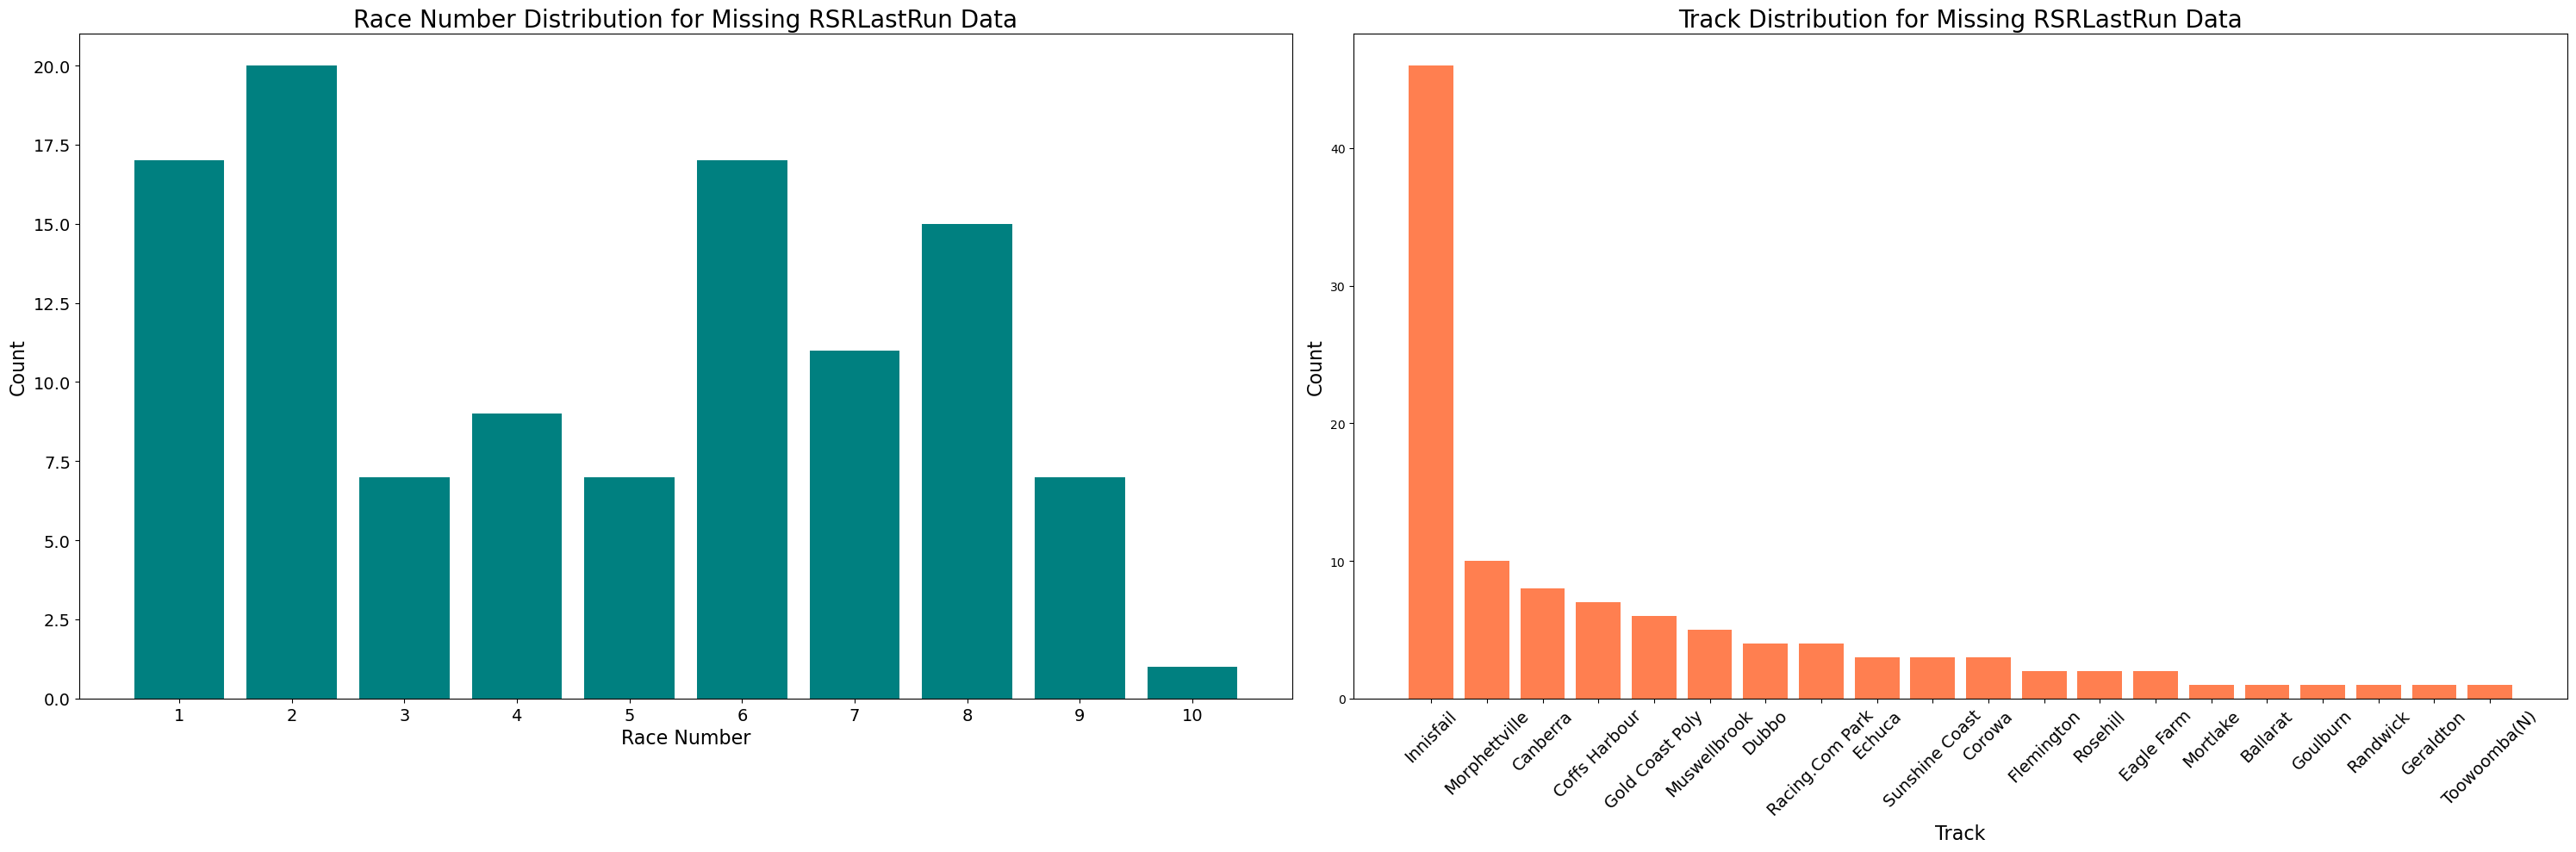

In [14]:
import matplotlib.pyplot as plt

horses_with_past_runs_missing_data = data[(data['RSRLastRun'].isnull()) & (data['Starts'] > 0)]

# Create a figure and a set of subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

# Race Number Distribution Analysis
race_number_distribution = horses_with_past_runs_missing_data['RaceNumber'].value_counts().sort_index()


# Plotting Race Number Distribution on the first subplot
ax[0].bar(race_number_distribution.index, race_number_distribution.values, color='teal')
ax[0].set_title('Race Number Distribution for Missing RSRLastRun Data', fontsize=20)
ax[0].set_xlabel('Race Number', fontsize=16)
ax[0].set_ylabel('Count', fontsize=16)
ax[0].set_xticks(race_number_distribution.index)
ax[0].tick_params(axis='both', labelsize=14)

# Track Distribution Analysis
track_distribution = horses_with_past_runs_missing_data['Track'].value_counts()

# Plotting Track Distribution on the second subplot
ax[1].bar(track_distribution.index, track_distribution.values, color='coral')
ax[1].set_title('Track Distribution for Missing RSRLastRun Data', fontsize=20)
ax[1].set_xlabel('Track', fontsize=16)
ax[1].set_ylabel('Count', fontsize=16)
ax[1].set_xticks(track_distribution.index)
ax[1].tick_params(axis='x', labelsize=14, rotation=45)

plt.tight_layout() 
plt.show()


- **Race Number Distribution:** The missing RSRLastRun data is spread across a wide range of race numbers. However, there seems to be no strong concentration in any specific race number, suggesting that the missing data is not tied to the position of the race within the event lineup.

- **Track Distribution:** data shows a notable variation across tracks, with Innisfail, having a significantly higher count of missing data suggests that certain locations might have specific issues or practices leading to more frequent occurrences of missing data.

These observations suggest that the missing **RSRLastRun** values for horses with previous track records are systematically related to the track, indicating a **Missing At Random (MAR) scenario**. As a result, **a model-based K-Nearest Neighbors (KNN) imputation method** has been chosen to address this issue. This method identifies the 'k' closest samples to the missing value based on other variables and imputes the missing RSRLastRun accordingly.

### Correlation Analysis

First, a Correlation Analysis is conducted to identify features suitable for inclusion in the imputation process. Features that exhibit high correlation with the target variable are generally considered preferable candidates for imputation rather than removal. This approach is predicated on the principle that variables closely related to the target can provide meaningful information for filling in missing values. However, caution is advised as an overreliance on highly correlated features can introduce multicollinearity, potentially skewing the model's accuracy and interpretability by inflating the variance of the coefficient estimates.

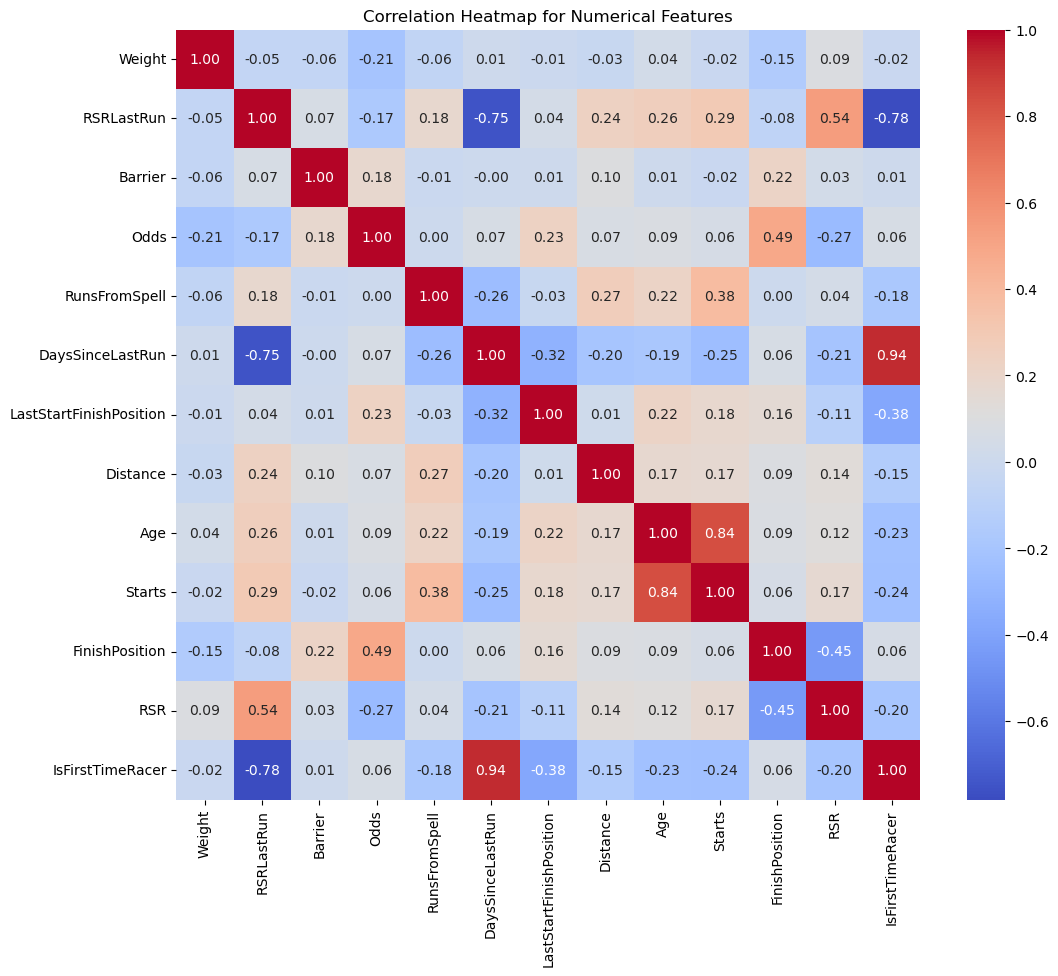

In [15]:
import seaborn as sns

# Filtering out the categorical variables to focus on numerical data only
numerical_features = ['Weight', 'RSRLastRun', 'Barrier', 'Odds', 'RunsFromSpell', 'DaysSinceLastRun', 
                      'LastStartFinishPosition', 'Distance', 'Age', 'Starts', 'FinishPosition', 'RSR', 'IsFirstTimeRacer']

# Calculating the correlation matrix for numerical features
correlation_matrix_numerical = data[numerical_features].corr()

# Plotting the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_numerical, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

### KNN Imputation

In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

# Filter out 'IsFirstTimeRacer' = 1 rows
df_filtered = data[data['IsFirstTimeRacer'] != 1]

# Define features for KNN imputation
features_for_imputation = [
    'RSRLastRun', 'RSR', 'Starts', 'Age', 
    'LastStartFinishPosition', 'Distance', 'DaysSinceLastRun', 'Weight',
]

# Filter the dataframe for the selected features
df_imputation = df_filtered[features_for_imputation]

# Standardize the data before KNN imputation
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_imputation) 

# Apply KNN imputer on standardized data
imputer = KNNImputer(n_neighbors=5)
imputed_scaled_data = imputer.fit_transform(scaled_features)

# Reverse the standardization to get back to the original scale
imputed_data = scaler.inverse_transform(imputed_scaled_data)

# Create a new dataframe with the imputed values, ensuring index alignment with df_filtered
df_imputed = pd.DataFrame(imputed_data, columns=features_for_imputation, index=df_filtered.index)

# Integrate the imputed data back into the original 'data' DataFrame
for column in features_for_imputation:
    # Update the original dataframe only where the imputation were performed
    data.loc[df_filtered.index, column] = df_imputed[column].values


### KNN Imputation Evaluation

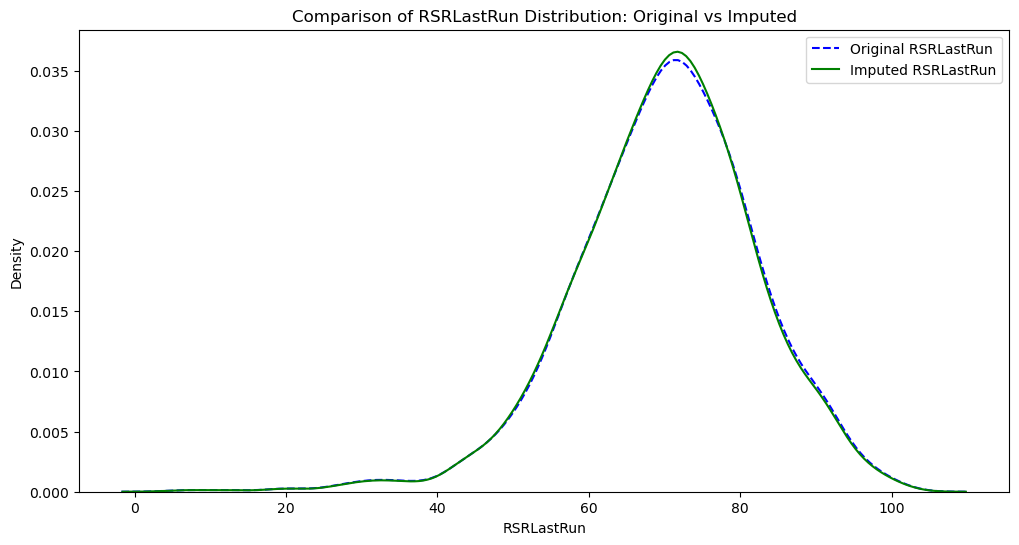

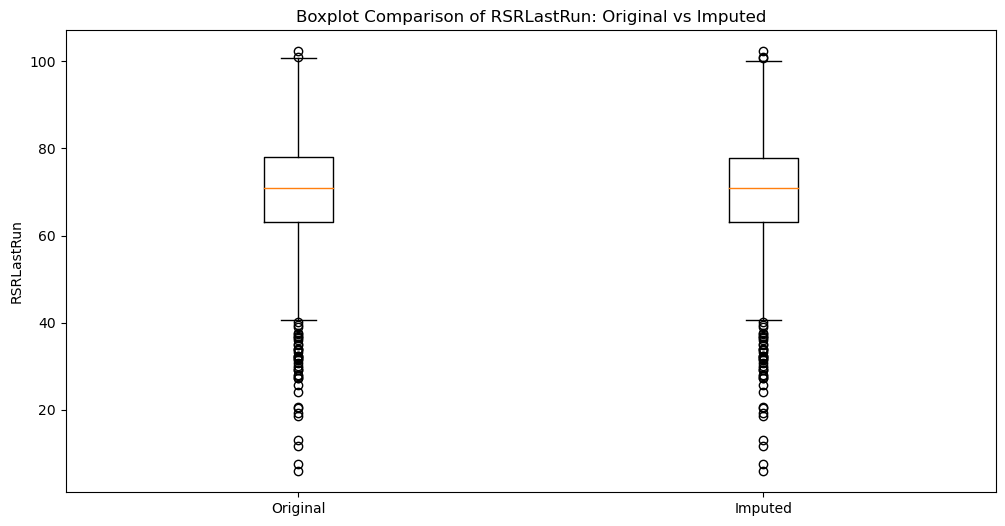

In [17]:
# Extract the original and imputed 'RSRLastRun' for visualization
original_rsrlastrun = df_filtered['RSRLastRun']
imputed_rsrlastrun = df_imputed['RSRLastRun']

# KDE plot for distribution comparison
plt.figure(figsize=(12, 6))
sns.kdeplot(original_rsrlastrun, label='Original RSRLastRun', linestyle="--", color="blue")
sns.kdeplot(imputed_rsrlastrun, label='Imputed RSRLastRun', color="green")
plt.title('Comparison of RSRLastRun Distribution: Original vs Imputed')
plt.xlabel('RSRLastRun')
plt.ylabel('Density')
plt.legend()
plt.show()

# Boxplot for median and quartile comparison
plt.figure(figsize=(12, 6))
data_to_plot = [original_rsrlastrun.dropna(), imputed_rsrlastrun]  # Drop NA for original to match sizes
plt.boxplot(data_to_plot, labels=['Original', 'Imputed'])
plt.title('Boxplot Comparison of RSRLastRun: Original vs Imputed')
plt.ylabel('RSRLastRun')
plt.show()


#### KDE Plot Interpretation:

- The Kernel Density Estimation (KDE) plot shows that the distribution of the imputed RSRLastRun closely follows the original data's distribution.
- The peaks of the distributions align well, suggesting that the central tendency hasn't been significantly altered.
- This is an indication that the **imputation process has maintained the overall structure of the data**.

#### Boxplot Interpretation:

- In the boxplot, the median (central line of the box) for both original and imputed data appears to be quite similar, which suggests that the imputation has preserved the central tendency of the RSRLastRun feature.
- The range also seems consistent between the original and imputed data, indicating that the **variability hasn't been significantly changed.**

### Conclusion
The imputation seems to have been done carefully, preserving the overall distribution and key statistical properties of the RSRLastRun variable.


In [18]:
# Checkpoint
data.to_csv('dataset.csv', index=False)

# Exploratory Data Analysis (EDA)

The purpose of this section is to provide statistics and visualizations for different variables, include insights gleaned from the cleaned data, and if necessary, do some additional processing of the data.

## Analyzing the Influence of Trainers and Jockeys on Finish Positions Using Boxplots

Given the potentially large number of unique trainers and jockeys, the focus will be on the most frequent ones to maintain clarity and interpretability in the visualization. This approach ensures that the data displayed represents the most impactful and common occurrences, thereby providing more meaningful insights while avoiding clutter and complexity in the visual representation.

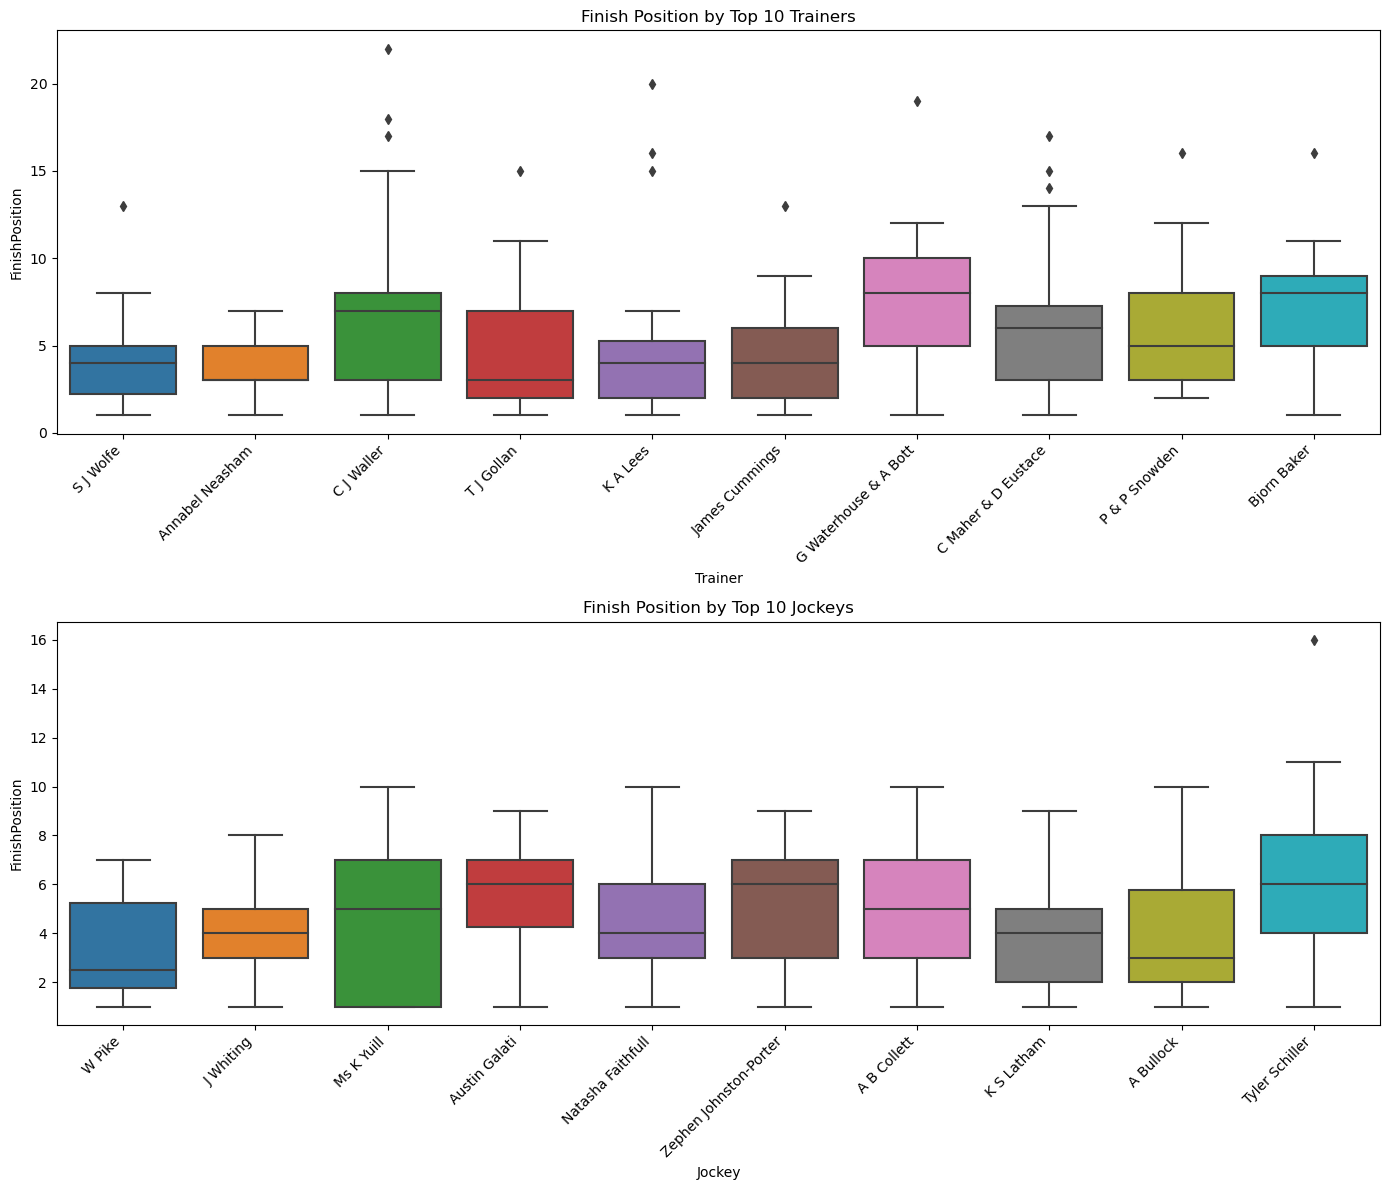

In [19]:
# Selecting the top 10 most frequent Trainers and Jockeys for visualization
top_trainers = data['Trainer'].value_counts().head(10).index
top_jockeys = data['Jockey'].value_counts().head(10).index

# Filtering the dataset for these top trainers and jockeys
data_top_trainers = data[data['Trainer'].isin(top_trainers)]
data_top_jockeys = data[data['Jockey'].isin(top_jockeys)]

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Box plot for Trainers vs FinishPosition
sns.boxplot(x='Trainer', y='FinishPosition', data=data_top_trainers, ax=ax[0])
ax[0].set_title('Finish Position by Top 10 Trainers')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')

# Box plot for Jockeys vs FinishPosition
sns.boxplot(x='Jockey', y='FinishPosition', data=data_top_jockeys, ax=ax[1])
ax[1].set_title('Finish Position by Top 10 Jockeys')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')

plt.tight_layout()
plt.show()

#### For Trainers:

Some trainers consistently have horses that finish in better positions than others. This suggests these trainers might be more skilled or effective. A trainer with a narrow spread (small boxes and short whiskers in the visualization) reliably prepares horses that perform similarly in each race, while a wider spread suggests less predictability in performance.

#### For Jockeys:
Jockeys also show differences in how well they finish races. Some jockeys consistently place higher, indicating they might be better at racing strategies or have superior skills.A smaller spread means the jockey's performance is more predictable and stable from race to race, while a larger spread shows more variability.

### Conclusion
For the categorical variables **Jockey** and **Trainer**, **Frequency Encoding** will be employed, where these variables are replaced with their respective frequencies. This method effectively manages high cardinality by reducing the complexity without excessively expanding the feature space.

### Frequency Encoding

In [20]:
def frequency_encoding(dataframe, column):
    # Calculate the frequency of each category
    frequency = dataframe[column].value_counts(normalize=True)
    # Replace each category with its frequency in the dataset
    dataframe[column] = dataframe[column].map(frequency)
    return dataframe

# List of categorical columns to encode
columns_to_encode = ['Track', 'Jockey', 'Trainer']

# Apply frequency encoding to each column
for column in columns_to_encode:
    df = frequency_encoding(data, column)
    
print(df.dtypes)

Date                        object
Track                      float64
RaceNumber                   int64
HorseNumber                  int64
HorseName                   object
Weight                     float64
RSRLastRun                 float64
Barrier                      int64
Jockey                     float64
Odds                       float64
Trainer                    float64
RunsFromSpell                int64
DaysSinceLastRun           float64
LastStartFinishPosition    float64
Distance                     int64
Age                          int64
Starts                     float64
FinishPosition               int64
RSR                        float64
IsFirstTimeRacer             int64
dtype: object


## Scatter Plot Analysis: Correlating Continuous Variables with Finish Positions
The analysis will concentrate on the variables 'Odds', 'Weight', 'RSRLastRun', and 'RSR'. This focus ensures that the most influential factors affecting race outcomes are considered.

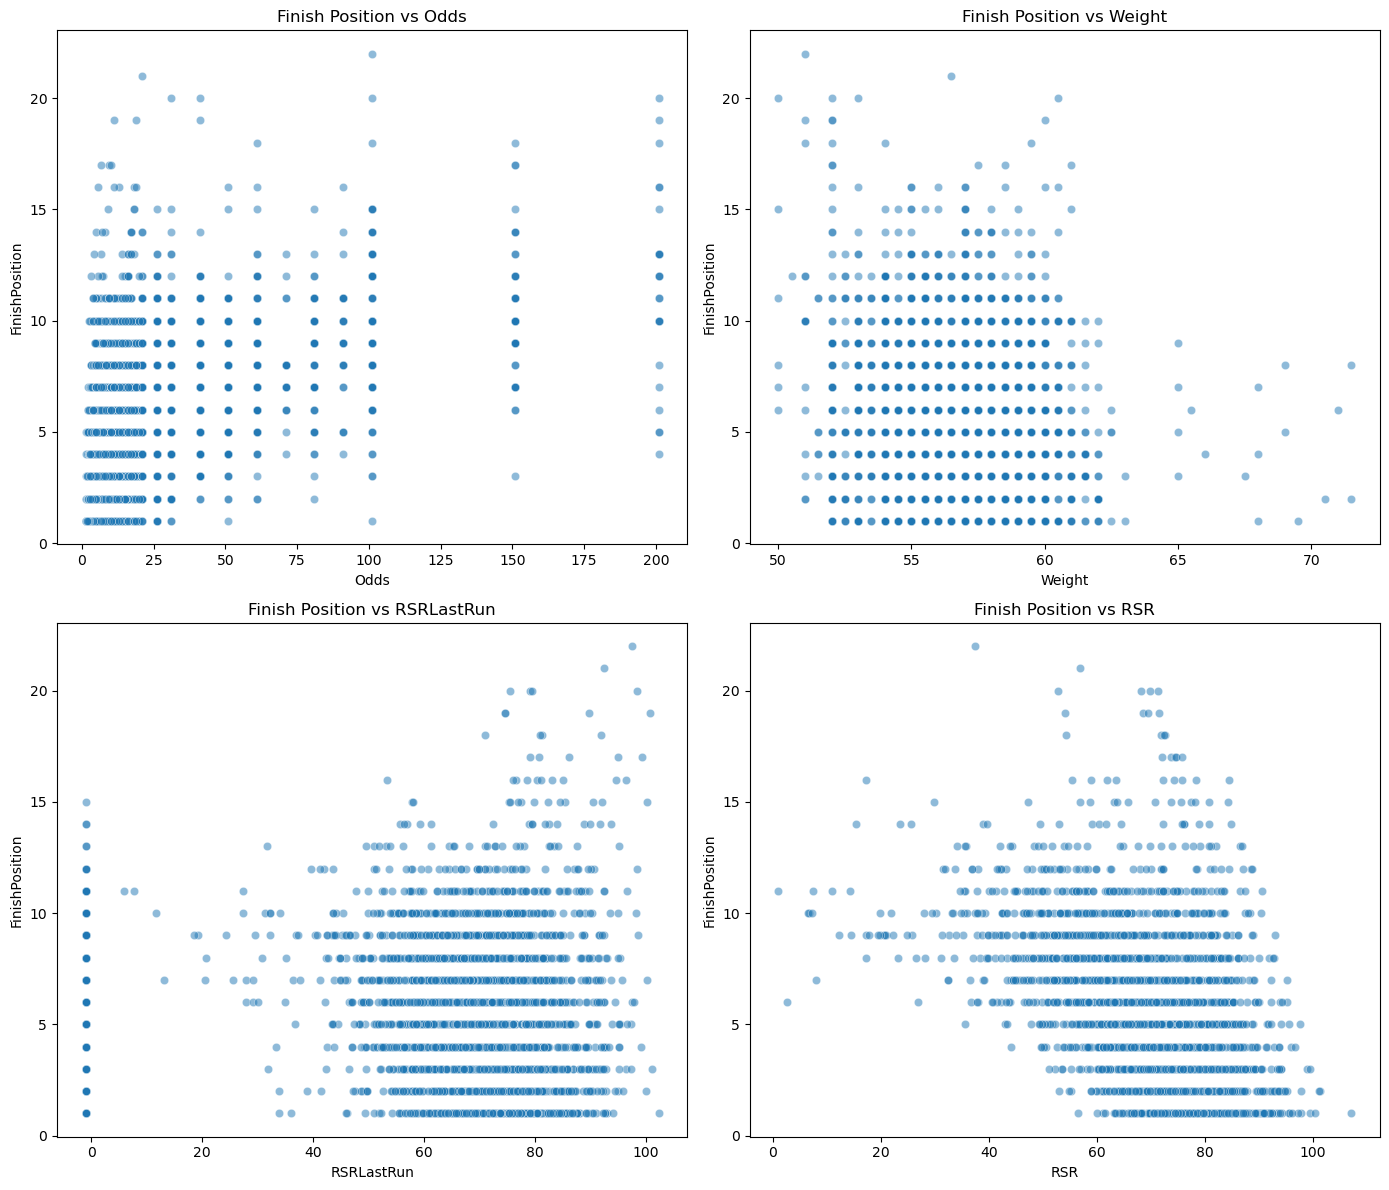

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# Scatter plot for Odds vs FinishPosition
sns.scatterplot(x='Odds', y='FinishPosition', data=data, ax=ax[0, 0], alpha=0.5)
ax[0, 0].set_title('Finish Position vs Odds')

# Scatter plot for Weight vs FinishPosition
sns.scatterplot(x='Weight', y='FinishPosition', data=data, ax=ax[0, 1], alpha=0.5)
ax[0, 1].set_title('Finish Position vs Weight')

# Scatter plot for RSRLastRun vs FinishPosition
sns.scatterplot(x='RSRLastRun', y='FinishPosition', data=data, ax=ax[1, 0], alpha=0.5)
ax[1, 0].set_title('Finish Position vs RSRLastRun')

# Scatter plot for RSR vs FinishPosition
sns.scatterplot(x='RSR', y='FinishPosition', data=data, ax=ax[1, 1], alpha=0.5)
ax[1, 1].set_title('Finish Position vs RSR')

plt.tight_layout()
plt.show()

#### Finish Position vs. Odds
The scatter plot suggests that while betting odds are a useful indicator of a horse's chances in a race, with lower odds typically indicating better performance, there's considerable variability, especially at higher odds. This variability indicates that other factors in addition to odds can influence the outcome of a race

#### Finish Position vs. Weight
The scatter plot analysis does not reveal a discernible trend between the weight carried by the horse and its finish position in the race. A significant impact of weight would typically manifest as a clear diagonal pattern in the scatter plot, either descending from top-left to bottom-right (suggesting that heavier weights correlate with poorer finish positions) or ascending in the opposite direction. The absence of such trends suggests that weight may not be a critical determinant of finish position in this particular dataset. 

#### Finish Position vs. RSRLastRun
While there is a concentration of better finishes in the middle range of RSRLastRun values, the relationship is not strong, and the variability is high. It's likely that the RSRLastRun value interacts with other factors to influence race outcomes. The new racers are represented along the y-axis at the far left of the scatter plot where RSRLastRun = -1. Their finish positions are spread out across the full range, indicating that being a new racer does not correspond to a specific finish position.

#### Finish Position vs. RSR
The scatter plot analysis indicates a more pronounced potential relationship between a horse's RSR and its finish position in a race, compared to other factors like weight. Generally, higher RSR values are associated with better finish positions, suggesting that RSR is a relevant and influential factor in predicting race outcomes. While the trend isn't absolute and there are exceptions, the overall pattern supports the idea that a horse's performance rating plays a significant role in how well it performs in races.

### Conclusion
The scatter plots for continuous variables against FinishPosition highlight the potential of Odds and RSR as strong predictors in modeling race outcomes. The insights also underscore the complexities and nuances in predicting race results, where factors such as Weight and RSRLastRun might influence outcomes in conjunction with other race conditions and horse attributes.

## Boxplot Visualization for Outlier Detection

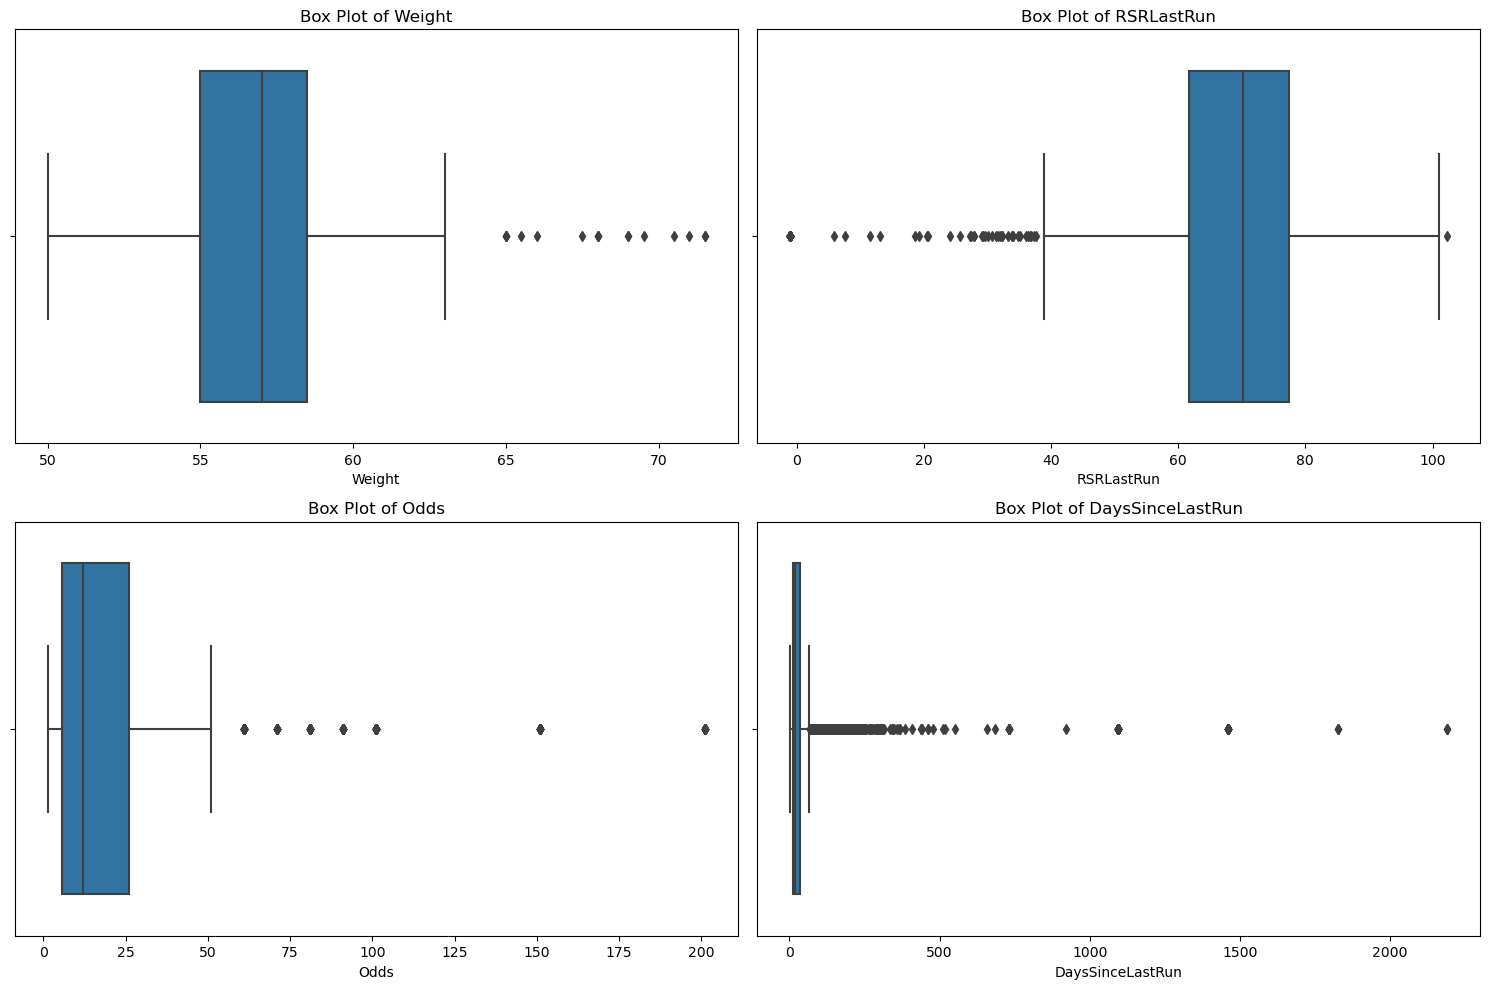

In [22]:
# preparing data correctly for plotting
cleaned_RSRLastRun = data[data['RSRLastRun'] >= 0]['RSRLastRun'].dropna()
cleaned_DaysSinceLastRun = data[(data['DaysSinceLastRun'] <= 365) & (data['DaysSinceLastRun'] >= 0)]['DaysSinceLastRun'].dropna()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Subplot 1: Weight
plt.subplot(221)
sns.boxplot(x=data['Weight'])
plt.title('Box Plot of Weight')

# Subplot 2: RSRLastRun
plt.subplot(222)
sns.boxplot(x=data['RSRLastRun'])
plt.title('Box Plot of RSRLastRun')

# Subplot 3: Odds
plt.subplot(223)
sns.boxplot(x=data['Odds'])
plt.title('Box Plot of Odds')

# Subplot 4: DaysSinceLastRun
plt.subplot(224)
sns.boxplot(x=data['DaysSinceLastRun'])
plt.title('Box Plot of DaysSinceLastRun')

plt.tight_layout()
plt.show()


### Conclusion
Considering the potential predictive value of outliers, employing models that are less sensitive to outliers proves more advantageous than excluding them. Tree-based models, such as Random Forests and Gradient Boosting Machines, are particularly robust to outliers and effectively handle both categorical and numerical data. These models operate by constructing multiple trees and making decisions based on the aggregate results, which naturally mitigates the influence of anomalous data points.

## Understanding Distribution of Finish Positions through Histogram Analysis

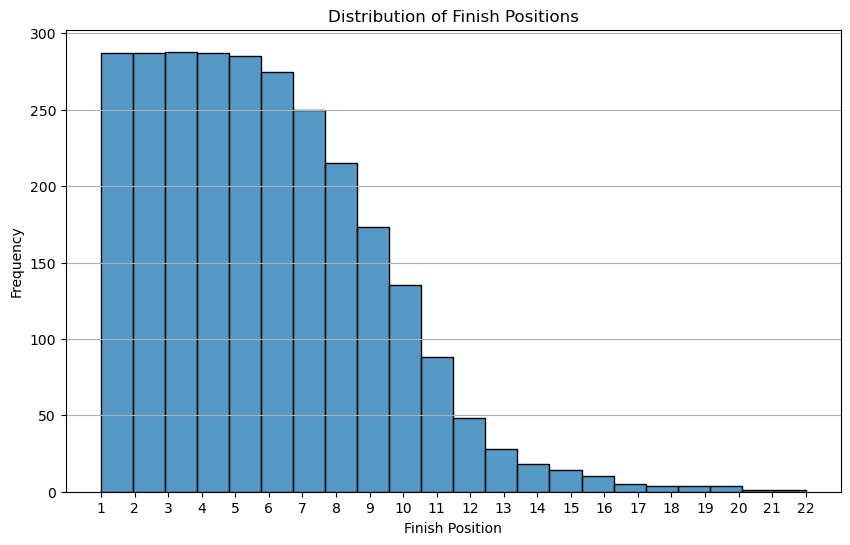

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(data['FinishPosition'], bins=int(data['FinishPosition'].max()), kde=False)
plt.title('Distribution of Finish Positions')
plt.xlabel('Finish Position')
plt.ylabel('Frequency')
plt.xticks(range(1, int(data['FinishPosition'].max())+1))
plt.grid(axis='y')
plt.show()


### Imbalance in the Dataset 
The decreasing frequency across finish positions suggests an imbalance in the dataset, with more instances of horses finishing in near to 1 compared to higher positions. This imbalance is typical in racing datasets but needs to be considered in model training to prevent bias towards more frequently occurring finish positions.

### Conclusion
 Given the imbalance:
 
- **Stratified Sampling:** During train-test splits, employing stratified sampling ensures that each split reflects the overall distribution of finish positions. This approach helps in maintaining the proportionality of the different classes, thus allowing the model to learn from a balanced representation of all outcomes.

- **Class Imbalance Techniques:** To address the imbalance directly, techniques such as oversampling the less frequent finish positions and undersampling the more frequent lower finish positions can be employed. These methods adjust the dataset to create a more balanced class distribution, which can help prevent the model from being biased toward the more common outcomes.

- **Random Forest Model:** Training a Random Forest model is advisable as this method is inherently more robust to imbalanced datasets. Random Forest operates by building multiple decision trees and averaging their predictions, which naturally handles the variance and biases associated with class imbalances.

# Methodology

## Model Selection
As a result of the analysis conducted, the decision to use a Random Forest model was made due to:
- **Working with Imbalanced Data:** Random Forest is generally good at handling imbalanced datasets, 
- **Non-linearity:** The model can capture complex nonlinear relationships between features 
- **Robustness:** Random Forest is quite robust to the presence of outliers in the dataset. Normalization or standardization primarily helps in managing the effects of outliers by scaling the features to a similar range 
- **Managing Overfitting:** Random Forest mitigates overfitting by averaging multiple decision trees trained on different parts of the data and features.


## Model Evaluation

Using **stratified K-fold cross-validation** is an excellent approach to ensure that the distribution of the target variable (categorized as binary for winning or not) is consistent across all folds. This method is particularly useful when the dataset features an imbalance in the target classes, as it maintains the proportion of each class in every subset.

In [24]:
df.drop('HorseName', axis=1, inplace=True)
df.drop('Date', axis=1, inplace=True)
print(df.dtypes)

Track                      float64
RaceNumber                   int64
HorseNumber                  int64
Weight                     float64
RSRLastRun                 float64
Barrier                      int64
Jockey                     float64
Odds                       float64
Trainer                    float64
RunsFromSpell                int64
DaysSinceLastRun           float64
LastStartFinishPosition    float64
Distance                     int64
Age                          int64
Starts                     float64
FinishPosition               int64
RSR                        float64
IsFirstTimeRacer             int64
dtype: object


In [25]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
 

# Create the 'IsWinner' column based on the 'FinishPosition'
df['IsWinner'] = (df['FinishPosition'] == 1).astype(int)

# Function to remove outliers using IQR
def remove_outliers(data, column_list):
    for column in column_list:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

# Removing outliers
df_clean = remove_outliers(df.copy(), ['Weight', 'Odds', 'DaysSinceLastRun', 'Distance', 'RSR'])

# Define datasets with and without outliers
datasets = {
    "With Outliers": df,
    "Without Outliers": df_clean
}

# Evaluate both datasets
for name, data in datasets.items():
    X = data.drop(['FinishPosition', 'IsWinner'], axis=1, errors='ignore')
    y = data['IsWinner']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Initialize the Random Forest classifier
    rf_model = RandomForestClassifier(random_state=42)

    # Setup cross-validation
    kf = StratifiedKFold(n_splits=5)

    # Perform cross-validation
    scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='accuracy')

    print(f"{name} - Cross-validated scores:", scores)
    print(f"{name} - Average score:", scores.mean())


With Outliers - Cross-validated scores: [0.90237467 0.90237467 0.88654354 0.89709763 0.9047619 ]
With Outliers - Average score: 0.8986304812162332
Without Outliers - Cross-validated scores: [0.875      0.87044534 0.87449393 0.89068826 0.87854251]
Without Outliers - Average score: 0.8778340080971659


### Conclusion
The scores from each fold of cross-validation are fairly close to each other, which is a good sign of model stability. Model does not exhibit significant variance in performance across different subsets of data, which helps in generalizing the results. The presence of outliers seems to positively impact the model’s performance and are informative for the prediction of the target variable.

# Model Tuning

To enhance performance, grid search was employed with the RandomForestClassifier to optimize hyperparameters. This method systematically tests a range of parameter combinations to identify the settings that yield the best model performance.

In [26]:
from sklearn.model_selection import GridSearchCV, train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Set up the parameter grid to tune
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum number of levels in each decision tree
    'min_samples_split': [2, 5, 10]  # Minimum number of data points placed in a node before the node is split
}

# Create a base model
rf = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=1, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.89


Results suggests that **limiting tree depth helps prevent overfitting**, and a **relatively high number of estimators (trees) improves performance**.

## Using other metrics to evaluate
Switching from evaluating solely on accuracy to more nuanced metrics that can provide deeper insights on how well  model predicts winners.

- **Precision:** Indicates the accuracy of positive predictions. Formulated as the ratio of true positives to the sum of true and false positives.
- **Recall (or Sensitivity):** Measures the ability of a model to find all the relevant cases (true positives) within a dataset.
- **F1-Score:** A weighted average of precision and recall. This score takes both false positives and false negatives into account. It is particularly useful when the class distribution is uneven.


In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the testing set
y_pred = grid_search.best_estimator_.predict(X_test)

# Classification report
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
print('Random Forest Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       454
           1       0.83      0.13      0.23        76

    accuracy                           0.87       530
   macro avg       0.85      0.56      0.58       530
weighted avg       0.87      0.87      0.83       530

Random Forest Confusion Matrix:
[[452   2]
 [ 66  10]]


The model performs well in identifying non-winners but struggles with correctly identifying winners. This is indicated by the high performance metrics for non-winners and low metrics for winners. This is mostly due to the imbalance in dataset where non-winners significantly outnumber winners.

## Comparison with Other Models
Gradient Boosting is a powerful model that builds trees sequentially, each attempting to correct the errors of the previous one. This model will be tested alongside the RandomForestClassifier to determine which is the optimal choice for the given data analysis task.

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
print("Gradient Boosting score: {:.2f}".format(gb.score(X_test, y_test)))

Gradient Boosting score: 0.86


In [29]:
# Predict on the test set
y_pred_gb = gb.predict(X_test)

# Evaluate the model
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

# Confusion Matrix
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       454
           1       0.52      0.20      0.29        76

    accuracy                           0.86       530
   macro avg       0.70      0.58      0.60       530
weighted avg       0.83      0.86      0.83       530

Gradient Boosting Confusion Matrix:
[[440  14]
 [ 61  15]]


Both models show on par high accuracy, precision, and recall for non-winners but lower metrics for winners.
The challenge with both models in predicting winners (Class 1) might be due to the imbalance between the number of winners and non-winners in dataset. Techniques like under and oversampling could potentially improve these metrics. 

## Resampling
The primary goal of this approach is to mitigate the effect of class imbalance, which can lead to a model that is biased towards the majority class. By ensuring the classes are equally represented, the model training can potentially improve its sensitivity towards the minority class.

In [30]:
# Separate the majority and minority classes
class_0 = df[df['IsWinner'] == 0]
class_1 = df[df['IsWinner'] == 1]

# Randomly sample from the majority class to match the number of the minority class
class_0_under = class_0.sample(len(class_1), random_state=42)

# Concatenate the minority class with the downsampled majority class
df_under = pd.concat([class_0_under, class_1], axis=0)

# Shuffle the dataset to mix up the rows
df_under = df_under.sample(frac=1, random_state=42)

# Prepare the feature matrix X and the target vector y from the resampled DataFrame
X_resampled = df_under.drop(['IsWinner', 'FinishPosition'], axis=1, errors='ignore')  # Adjust this line if there are other columns to drop
y_resampled = df_under['IsWinner']

X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

### Using RandomForestClassifier with adjusted Weights

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the model with class weights to balance
rf_weighted = RandomForestClassifier(random_state=42, class_weight='balanced')

# Fit the model on the resampled data
rf_weighted.fit(X_train_resampled, y_train_resampled)

# Predict on the test set created from the resampled dataset
y_pred_weighted = rf_weighted.predict(X_test_resampled)

# Evaluate the model
print("Random Forest Classification Report After Class Weight Adjustment:")
print(classification_report(y_test_resampled, y_pred_weighted))
print("Random Forest Confusion Matrix After Class Weight Adjustment:")
print(confusion_matrix(y_test_resampled, y_pred_weighted))


Random Forest Classification Report After Class Weight Adjustment:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78        87
           1       0.78      0.77      0.77        86

    accuracy                           0.77       173
   macro avg       0.77      0.77      0.77       173
weighted avg       0.77      0.77      0.77       173

Random Forest Confusion Matrix After Class Weight Adjustment:
[[68 19]
 [20 66]]


### Using GradientBoostingClassifier with adjusted Weights

In [32]:
gb_adjusted = GradientBoostingClassifier(random_state=42)

# Fit the model
gb_adjusted.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
y_pred_gb = gb_adjusted.predict(X_test_resampled)

print("Gradient Boosting Classification Report:")
print(classification_report(y_test_resampled, y_pred_gb))
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test_resampled, y_pred_gb))

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80        87
           1       0.80      0.78      0.79        86

    accuracy                           0.79       173
   macro avg       0.79      0.79      0.79       173
weighted avg       0.79      0.79      0.79       173

Gradient Boosting Confusion Matrix:
[[70 17]
 [19 67]]


# Best Model Overview

The analysis revealed that while both RandomForest and GradientBoosting classifiers are on par and capable of high overall accuracy, they face challenges in correctly predicting the minority class (winners). The resampling strategy effectively addressed some of the issues caused by class imbalance, resulting in more balanced performance metrics.
The Gradient **Boosting Classifier** shows **slightly better performance** on the resampled data, making it a strong candidate for the best model.


## Gradient Boosting Results:

### Model Performance Analysis in Horse Betting Context

#### Precision for Class 0 (non-winners): 79%
When the model predicts that a horse will not win the race, it is correct about 79% of the time. This high precision is critical for bettors who base their decisions on avoiding bets on horses that are unlikely to win.

#### Recall for Class 0 (non-winners): 80%
Of all the horses that do not win races, the model successfully identifies 80% of them as non-winners. This means it's quite reliable in flagging horses that are less likely to succeed, allowing bettors to focus their attention and resources on more promising candidates.

#### Precision for Class 1 (winners): 80%
When the model predicts a horse as a winner, it is correct 80% of the time. For bettors, this means if a bet is placed based on the model’s prediction of a winner, there is a high likelihood that the bet will be profitable. This precision rate helps in selecting bets that have a high chance of yielding returns.

#### Recall for Class 1 (winners): 78%
The model is able to identify 78% of the actual winners. This is crucial for ensuring that most of the winning horses are not missed out on. For bettors, it means the model provides a robust strategy to capture a large portion of potential winning opportunities, minimizing the risk of overlooking a profitable bet.

#### Overall Accuracy: 79%
The model correctly predicts the outcome (win or not win) for 79% of the horses. For bettors, this accuracy ensures that the model is reliable for making betting decisions across a range of races and conditions.

#### Macro Average F1-Score: 79%
This balanced score between precision and recall for both winners and non-winners suggests that the model is consistently reliable across both identifying winners and avoiding non-winners. For horse betting, this means the model is equally adept at recommending bets on potential winners as it is at advising against bets on likely losers.


## Considerations

- **Generalization:** The model performs well on the current dataset, but ensuring it generalizes to new, unseen data is crucial.

- **False Positives and False Negatives:** There are still some false positives and negatives. Depending on the stakes of betting or the application, further reducing these through threshold tuning or more sophisticated models might be necessary.
